# **Importing all necessary libraries**

In [ ]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import cv2
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# **Defining all necessary variables, for further setting of transformer's architecture**

In [ ]:
img_size=128
patch_size=8
num_patches=(img_size//patch_size)**2
emb_dim=512
mlp_dim=256
n_heads=6
dropout_enc=0.2
dropout_head=0.3
n_layers=1

# **Loading dataset, and saving it into arrays**

 ## **For model training was used dataset with skin cancer images: https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign/**

In [ ]:
X=np.zeros(shape=(7023,img_size,img_size,3),dtype='uint8')
y=[]
i=0
for img in os.listdir('/kaggle/input/skin-cancer-malignant-vs-benign/train/benign/'):
    image=cv2.imread('/kaggle/input/skin-cancer-malignant-vs-benign/train/benign/'+img)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image=cv2.resize(image,(img_size,img_size))
    X[i]=image
    y.append(0)
    i+=1
for img in os.listdir('/kaggle/input/skin-cancer-malignant-vs-benign/test/benign/'):
    image=cv2.imread('/kaggle/input/skin-cancer-malignant-vs-benign/test/benign/'+img)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image=cv2.resize(image,(img_size,img_size))
    X[i]=image
    y.append(0)
    i+=1
for img in os.listdir('/kaggle/input/skin-cancer-malignant-vs-benign/train/malignant/'):
    image=cv2.imread('/kaggle/input/skin-cancer-malignant-vs-benign/train/malignant/'+img)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image=cv2.resize(image,(img_size,img_size))
    X[i]=image
    y.append(1)
    i+=1
for img in os.listdir('/kaggle/input/skin-cancer-malignant-vs-benign/test/malignant/'):
    image=cv2.imread('/kaggle/input/skin-cancer-malignant-vs-benign/test/malignant/'+img)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image=cv2.resize(image,(img_size,img_size))
    X[i]=image
    y.append(1)
    i+=1
X=X[:i]
y=np.array(y)
print(X.shape)
print(y.shape)

(3297, 128, 128, 3)
(3297,)


# **Visualizing distribution of classes into dataset**

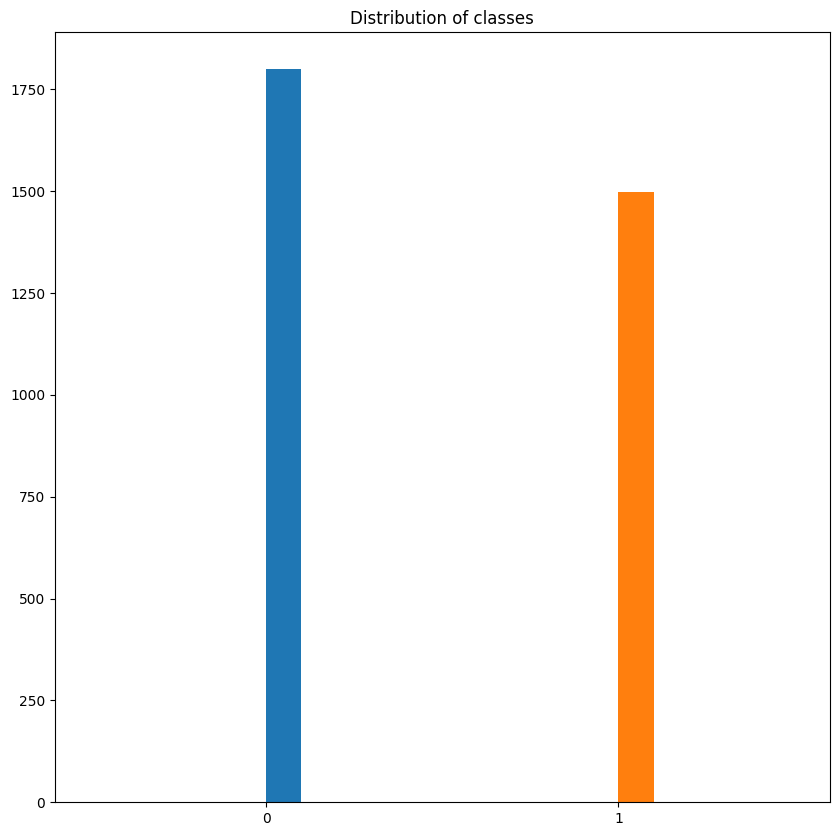

In [ ]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1)
ax.set_title('Distribution of classes')
ax.hist(y[y==0])
ax.hist(y[y==1])
plt.xticks([0,1])
plt.show()

# **Visualizing some images from the dataset**

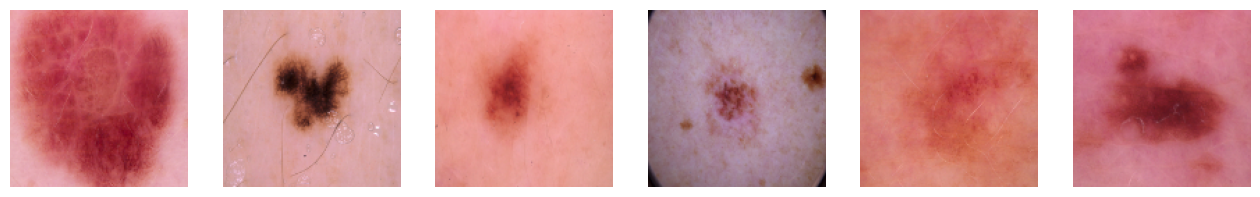

In [ ]:
fig=plt.figure(figsize=(16,16))
for i in range(6):
    ax=fig.add_subplot(1,6,i+1)
    ax.axis('off')
    ax.imshow(X[i])
plt.show()

# **Defining function for transforming images into arrays of flattened patches**

In [ ]:
def transform_images(images):
    patches_data=np.zeros(shape=(images.shape[0],num_patches,patch_size*patch_size*3),dtype='uint8')
    for i in range(images.shape[0]):
        for j in range(int(num_patches**0.5)):
            for k in range(int(num_patches**0.5)):
                patch=images[i,patch_size*j:patch_size*(j+1),patch_size*k:patch_size*(k+1)]
                patches_data[i,j*int(num_patches**0.5)+k]=np.reshape(a=patch,newshape=patch_size*patch_size*3)
    return patches_data

# **Splitting dataset on train,test and validation set**

In [ ]:
X_train,X_val,y_train,y_val=train_test_split(X,y,train_size=0.8,random_state=1)
X_val,X_test,y_val,y_test=train_test_split(X_val,y_val,test_size=0.5,random_state=1)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2637, 128, 128, 3)
(330, 128, 128, 3)
(330, 128, 128, 3)


# **Applying some data augmentation**

In [ ]:
X_train=np.concatenate([X_train,np.array([cv2.flip(img,1) for img in X_train])],axis=0)
y_train=np.concatenate([y_train,y_train],axis=0)
X_train=np.concatenate([X_train,np.array([cv2.flip(img,0) for img in X_train])],axis=0)
y_train=np.concatenate([y_train,y_train],axis=0)
X_train=np.concatenate([X_train,np.array([cv2.resize(img[5:img_size-5,5:img_size-5],(img_size,img_size)) for img in X_train])],axis=0)
y_train=np.concatenate([y_train,y_train],axis=0)
X_train=np.concatenate([X_train,np.array([cv2.resize(img[10:img_size-10,10:img_size-10],(img_size,img_size)) for img in X_train])],axis=0)
y_train=np.concatenate([y_train,y_train],axis=0)
X_train,y_train=shuffle(X_train,y_train,random_state=1)
print(X_train.shape)

(42192, 128, 128, 3)


# **Applying and visualizing transformation of images to patches**

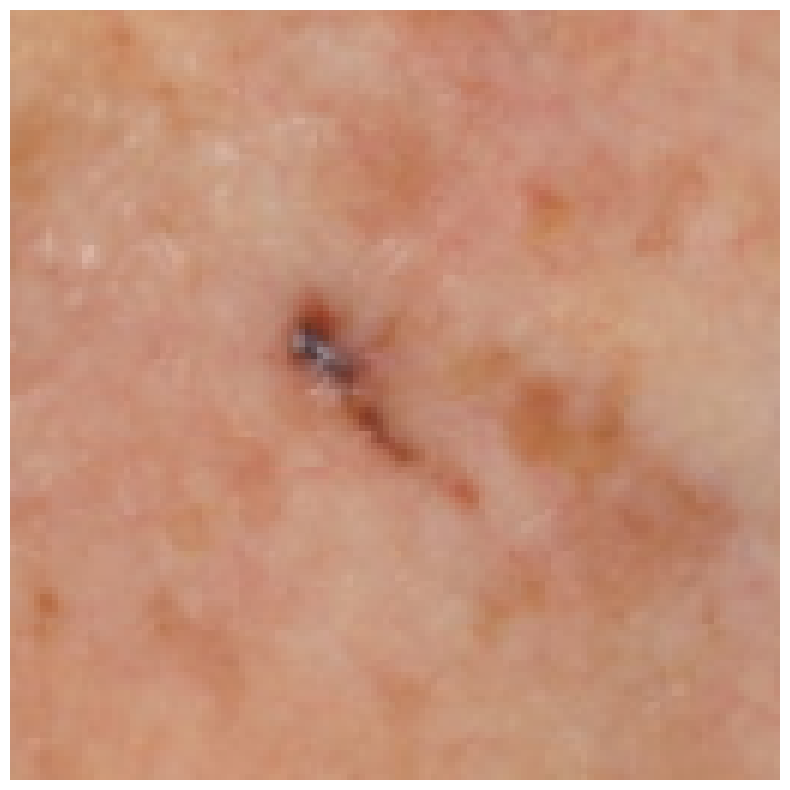

In [ ]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1)
ax.axis('off')
ax.imshow(X_train[0])
plt.show()

In [ ]:
X_train=transform_images(X_train)
print(X_train.shape)
X_val=transform_images(X_val)
print(X_val.shape)

(42192, 256, 192)
(330, 256, 192)


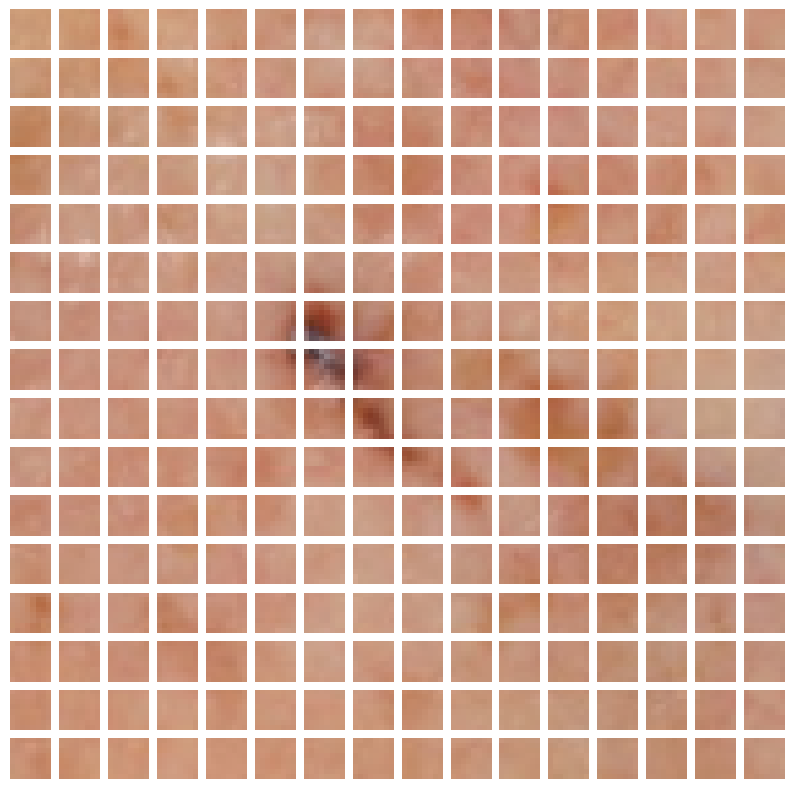

In [ ]:
fig=plt.figure(figsize=(10,10))
for i in range(num_patches):
    ax=fig.add_subplot(int(num_patches**0.5),int(num_patches**0.5),i+1)
    ax.axis('off')
    patch=X_train[0,i,:].reshape((patch_size,patch_size,3))
    ax.imshow(patch)
plt.show()

# **Converting datasets to the format, necessary for learning in TensorFlow**

In [ ]:
BATCH_SIZE=256
X_train=tf.convert_to_tensor(X_train)
print(X_train.shape)
y_train=tf.convert_to_tensor(y_train)
print(y_train.shape)
X_val=tf.convert_to_tensor(X_val)
print(X_val.shape)
y_val=tf.convert_to_tensor(y_val)
print(y_val.shape)
train_data=tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(BATCH_SIZE)
val_data=tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(BATCH_SIZE)

(42192, 256, 192)
(42192,)
(330, 256, 192)
(330,)


# **Defining functions/classes for different ViT's modules/steps**

# **Embedding function for flattened patches**

In [ ]:
def patch_embedding(In):
    return tf.keras.layers.Dense(units=emb_dim,activation=None)(In)

# **Embedding function for positions**

In [ ]:
def position_embedding():
    positions=tf.range(0,num_patches,1)
    return tf.keras.layers.Embedding(input_dim=num_patches,output_dim=emb_dim)(positions)

# **Class for extra learnable (class) embedding**

In [ ]:
class ClassToken(tf.keras.layers.Layer):
    def __init__(self):
        super(ClassToken,self).__init__()
    def build(self,input_shape):
        self.w=tf.Variable(initial_value=tf.random_normal_initializer()(shape=(1,1,input_shape[-1]),dtype=tf.float32),trainable=True)
    def call(self,inputs):
        batch_size=tf.shape(inputs)[0]
        hid_dim=self.w.shape[-1]
        cls=tf.broadcast_to(self.w,[batch_size,1,hid_dim])
        cls=tf.cast(cls,dtype=inputs.dtype)
        return cls

# **Function for transformer encoder**

In [ ]:
def transformer_encoder(In):
    x1=tf.keras.layers.LayerNormalization()(In)
    x2=tf.keras.layers.MultiHeadAttention(num_heads=n_heads,key_dim=emb_dim)(x1,x1)
    x3=tf.keras.layers.Add()([x2,x1])
    x4=tf.keras.layers.LayerNormalization()(x3)
    x5=tf.keras.layers.Dense(units=mlp_dim,activation='gelu')(x4)
    x6=tf.keras.layers.Dropout(dropout_enc)(x5)
    x7=tf.keras.layers.Dense(units=emb_dim,activation='gelu')(x6)
    x8=tf.keras.layers.Add()([x7,x3])
    return x8

# **Function for complete ViT model**

In [ ]:
def ViT():
    In=tf.keras.Input(shape=(num_patches,patch_size*patch_size*3))
    ptc_emb=patch_embedding(In)
    pos_emb=position_embedding()
    emb=ptc_emb+pos_emb
    token=ClassToken()(emb)
    x=tf.keras.layers.Concatenate(axis=1)([token,emb])
    for i in range(n_layers):
        x=transformer_encoder(x)
    x=tf.keras.layers.LayerNormalization()(x)
    x=x[:,0]
    x=tf.keras.layers.Dropout(dropout_head)(x)
    x=tf.keras.layers.Dense(units=mlp_dim,activation='gelu')(x)
    x=tf.keras.layers.Dropout(dropout_head/2)(x)
    Out=tf.keras.layers.Dense(units=1,activation='sigmoid')(x)
    return tf.keras.models.Model(inputs=In,outputs=Out,name='Vit')

# **Defining and learning ViT**

In [ ]:
EPOCHS=50
vit=ViT()
vit.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=1e-4),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['Accuracy'])
vit.summary()
es=tf.keras.callbacks.EarlyStopping(monitor='val_Accuracy',min_delta=0,patience=2,mode='max',restore_best_weights=True)
hist=vit.fit(train_data,epochs=EPOCHS,validation_data=val_data,callbacks=[es])

Model: "Vit"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 192)]           0         []                            
                                                                                                  
 dense (Dense)               (None, 256, 512)             98816     ['input_1[0][0]']             
                                                                                                  
 tf.__operators__.add (TFOp  (None, 256, 512)             0         ['dense[0][0]']               
 Lambda)                                                                                          
                                                                                                  
 class_token (ClassToken)    (None, 1, 512)               512       ['tf.__operators__.add[0][0]

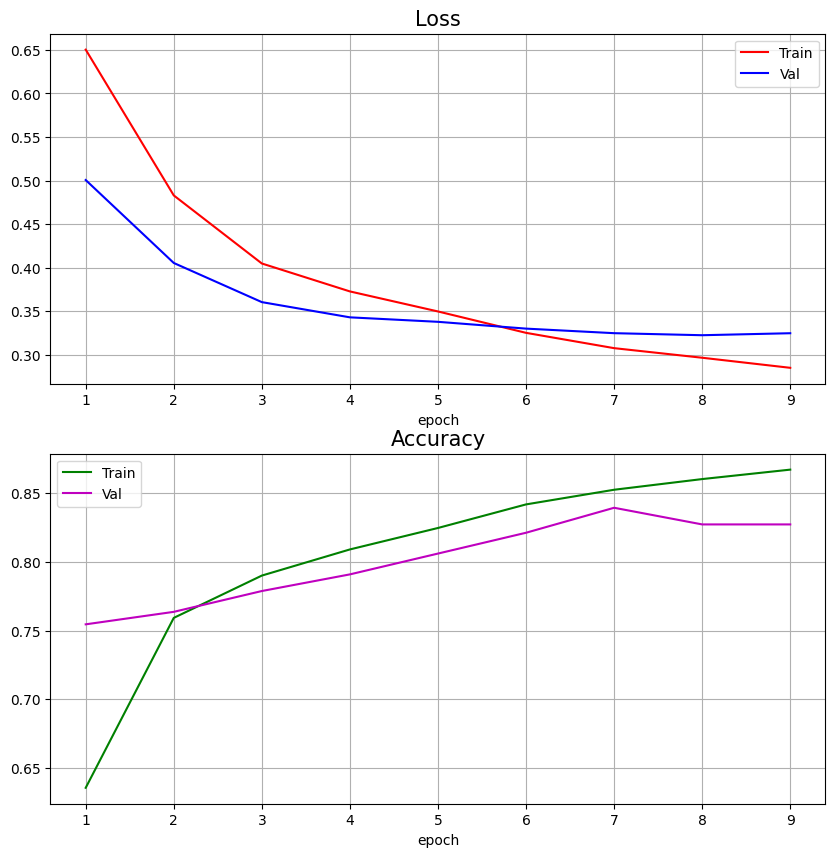

In [ ]:
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['Accuracy']
val_acc=hist.history['val_Accuracy']
epochs=[i for i in range(1,len(val_loss)+1)]
fig=plt.figure(figsize=(10,10))
ax1=fig.add_subplot(2,1,1)
ax1.set_title('Loss',fontsize=15)
ax1.plot(epochs,train_loss,color='r',label='Train')
ax1.plot(epochs,val_loss,color='b',label='Val')
ax1.set_xlabel('epoch')
ax1.grid()
ax1.legend()
ax2=fig.add_subplot(2,1,2)
ax2.set_title('Accuracy',fontsize=15)
ax2.plot(epochs,train_acc,color='g',label='Train')
ax2.plot(epochs,val_acc,color='m',label='Val')
ax2.set_xlabel('epoch')
ax2.grid()
ax2.legend()
plt.show()

# **Evaluating and visualizing ViT's performance on a test set**

In [ ]:
vit.evaluate(tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(transform_images(X_test)),tf.convert_to_tensor(y_test))).batch(BATCH_SIZE))

2/2 [==============================] - 0s 74ms/step - loss: 0.2836 - Accuracy: 0.8606


[0.28357744216918945, 0.8606060743331909]

1/1 [==============================] - 0s 334ms/step


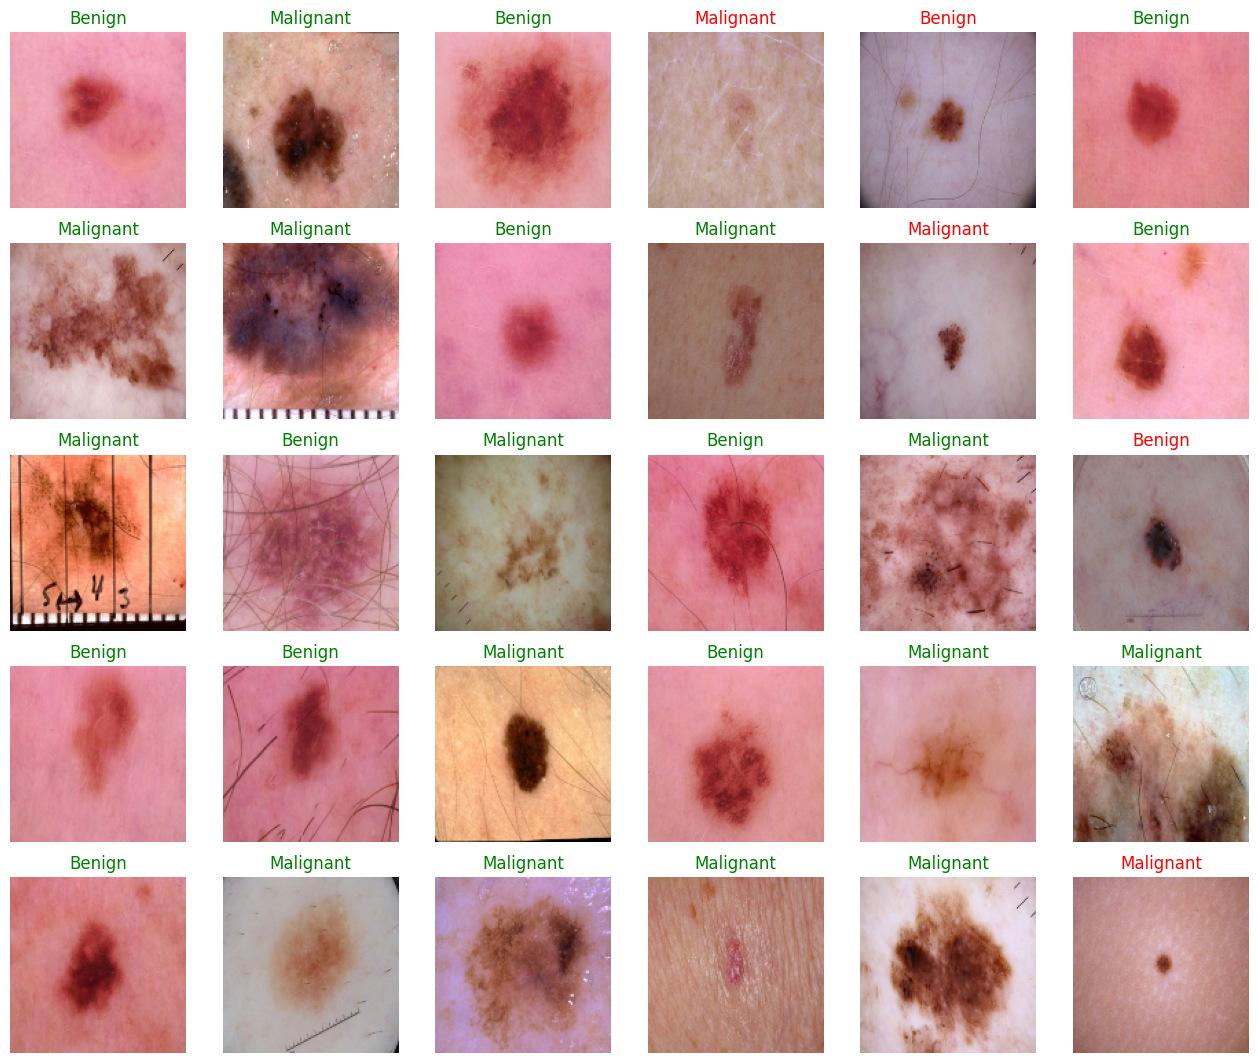

In [ ]:
numb=30
pred=vit.predict(transform_images(X_test[:numb]))
pred=1*(pred>0.5)
fig=plt.figure(figsize=(16,16))
for i in range(numb):
    ax=fig.add_subplot(1+numb//6,6,i+1)
    ax.axis('off')
    if pred[i]==0 and y_test[i]==0:
        ax.set_title('Benign',color='g')
    elif pred[i]==1 and y_test[i]==1:
        ax.set_title('Malignant',color='g')
    elif pred[i]==1 and y_test[i]==0:
        ax.set_title('Malignant',color='r')
    else:
        ax.set_title('Benign',color='r')
    ax.imshow(X_test[i])
plt.show()